In [23]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [24]:
# determine working directories (notebook CWD)
script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
data_dir = parent_dir + '\\1_Data'

In [25]:
# Read data
excel_file = os.path.join(data_dir, 'IEG_ICRR_PPAR_Ratings_2025-03-12.xlsx')
df = pd.read_excel(excel_file)

In [26]:
# Filter the dataset to include only projects approved between 2015 to 2025 that are mapped to the Human Development Practice Group. 
df2 = df[
    (df['Approval FY'] >= 2015) &
    (df['Approval FY'] <= 2025) &
    (df['Practice Group'] == 'HD')
]

In [27]:
import requests
import pdfplumber  # pip install pdfplumber
from io import BytesIO
from tqdm import tqdm

# Para ver el progreso
tqdm.pandas()

def extract_text_from_pdf(url):
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        with pdfplumber.open(BytesIO(response.content)) as pdf:
            text = ''.join(page.extract_text() or '' for page in pdf.pages)
        return text.strip()
    except Exception as e:
        return f"[ERROR] {e}"

# Aplica la función a cada fila
df2['Full Text'] = df2['PDF'].progress_apply(extract_text_from_pdf)

100%|██████████| 328/328 [19:20<00:00,  3.54s/it]
C:\Users\wb592581\AppData\Local\Temp\ipykernel_30124\2997631929.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Full Text'] = df2['PDF'].progress_apply(extract_text_from_pdf)


In [28]:
import re

def extract_section(text, start_pattern, end_pattern, label):
    # Compilar los patrones con tolerancia flexible
    start_regex = re.compile(rf"{start_pattern}", re.IGNORECASE)
    end_regex = re.compile(rf"{end_pattern}", re.IGNORECASE)

    # Buscar líneas
    lines = text.splitlines()
    start_idx = end_idx = None

    for i, line in enumerate(lines):
        if start_idx is None and start_regex.search(line.strip()):
            start_idx = i
        elif start_idx is not None and end_regex.search(line.strip()):
            end_idx = i
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        return "\n".join(lines[start_idx:end_idx+1])
    else:
        return ""  # Si no se encuentra una sección válida

# Aplicar al DataFrame
def extract_sections(row):
    text = row['Full Text']
    me_section = extract_section(
        text,
        start_pattern=r"\bM&E\s+Design.*Utilization\b", 
        end_pattern=r"\bM&E\s+Quality\s+Rating\b", 
        label="M&E Section"
    )
    me_design = extract_section(
        text,
        start_pattern=r"\bM&E\s+Design\b", 
        end_pattern=r"\bM&E\s+Implementation\b", 
        label="M&E: Design"
    )
    me_implementation = extract_section(
        text,
        start_pattern=r"\bM&E\s+Implementation\b", 
        end_pattern=r"\bM&E\s+Utilization\b", 
        label="M&E: Implementation"
    )
    me_utilization = extract_section(
        text,
        start_pattern=r"\bM&E\s+Utilization\b", 
        end_pattern=r"\bM&E\s+Quality\s+Rating\b", 
        label="M&E: Utilization"
    )
    outcome_section = extract_section(
        text,
        start_pattern = r'[567][\.\)]?\s*Outcome\b.*',
        end_pattern=r'(IEG\s+)?Outcome\s+Rating\b.*',
        label="Outcome_section"
    )
    return pd.Series({'M&E Section': me_section, 'M&E: Design': me_design, 
                      'M&E: Implementation': me_implementation, 'M&E: Utilization': me_utilization, 
                      'Outcome_section': outcome_section})

# Aplica al DataFrame df2
df2[['M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Outcome_section']] = df2.apply(extract_sections, axis=1)

C:\Users\wb592581\AppData\Local\Temp\ipykernel_30124\3998325397.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Outcome_section']] = df2.apply(extract_sections, axis=1)
C:\Users\wb592581\AppData\Local\Temp\ipykernel_30124\3998325397.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Outcome_section']] = df2.apply(extract_sections, axis=1)
C:\Use

In [29]:
rating_mapping = {
    'Highly Unsatisfactory': 1, 'Unsatisfactory': 2, 'Moderately Unsatisfactory': 3,
    'Moderately Satisfactory': 4, 'Satisfactory': 5, 'Highly Satisfactory': 6
}

# Outcome score
df2['outcome_score'] = df2['IEG Outcome Ratings'].map(rating_mapping)
df2.drop(columns=['IEG Outcome Ratings'], inplace=True, errors='ignore')

C:\Users\wb592581\AppData\Local\Temp\ipykernel_30124\69297399.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['outcome_score'] = df2['IEG Outcome Ratings'].map(rating_mapping)
C:\Users\wb592581\AppData\Local\Temp\ipykernel_30124\69297399.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(columns=['IEG Outcome Ratings'], inplace=True, errors='ignore')


In [40]:
import string
from sklearn.feature_extraction.text import TfidfVectorizer

custom_stopwords = set([
    "pbf", "ndc", "eur", "rating", "icr", "outcome",
    "unsatisfactory", "satisfactory", "moderately", "highly",
    "monitoring", "design", "implementation", "utilization",
    "lesson", "evaluation", "modest", "bme", "cme", "dlis", "high", 
    "efficiency", "negligible", "substantial", "lessons", "ppmp", "piu",
    "indicators", "independent", "group"
])

# Text cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces

    # Remove only full-word stopwords using regex
    pattern = r'\b(?:' + '|'.join(re.escape(word) for word in custom_stopwords) + r')\b'
    text = re.sub(pattern, '', text)

    # Clean extra spaces that may remain after removing words
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Variables de texto
text_vars = ['Full Text', 'M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Lesson']

df2_cleaned = df2.copy()
for var in text_vars:
    df2_cleaned[var] = df2_cleaned[var].fillna("").apply(clean_text)

In [41]:
dir2 = r"C:\Users\wb592581\Documents"
import os 

In [42]:
import optuna
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from mord import OrdinalRidge  # ordinal regression package
import pickle

# Diccionario para guardar resultados
results = {}
N_TRIALS = 15

# Loop por variable de texto
for var in text_vars:
    print(f"\nProcesando variable de texto: {var}")
    
    # TF-IDF con n-gramas de 1 a 3
    tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000, stop_words='english')
    X_tfidf = tfidf.fit_transform(df2_cleaned[var])
    y = df2_cleaned["outcome_score"].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

    model_results = {}

    # ------------------ LGBM ------------------
    def objective_lgbm(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True)
        }
        model = LGBMRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds, squared=False)  # RMSE

    study_lgbm = optuna.create_study(direction='minimize')
    study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS)

    best_lgbm = LGBMRegressor(**study_lgbm.best_params)
    best_lgbm.fit(X_train, y_train)
    model_results['lgbm'] = (best_lgbm, tfidf)

    # ------------------ RF ------------------
    def objective_rf(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15)
        }
        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds, squared=False)

    study_rf = optuna.create_study(direction='minimize')
    study_rf.optimize(objective_rf, n_trials=N_TRIALS)

    best_rf = RandomForestRegressor(**study_rf.best_params)
    best_rf.fit(X_train, y_train)
    model_results['rf'] = (best_rf, tfidf)

    # ------------------ ORDINAL ------------------
    model_ordinal = OrdinalRidge()
    model_ordinal.fit(X_train, y_train)
    model_results['ordinal'] = (model_ordinal, tfidf)

    # Guardar resultados en archivo pickle
    for model_name, (model, vec) in model_results.items():
        filename = os.path.join(dir2, f"model_{model_name}_{var}.pkl")
        with open(filename, 'wb') as f:
            pickle.dump({'model': model, 'vectorizer': vec}, f)

    results[var] = model_results


Procesando variable de texto: Full Text


[I 2025-06-22 12:33:29,449] A new study created in memory with name: no-name-4faa9e24-6d64-4ee4-8da3-fd8cb6418bc8


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:33:35,290] Trial 0 finished with value: 0.9101102361761003 and parameters: {'n_estimators': 382, 'max_depth': 8, 'learning_rate': 0.002404135873984137}. Best is trial 0 with value: 0.9101102361761003.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:33:38,237] Trial 1 finished with value: 0.8136008533560956 and parameters: {'n_estimators': 154, 'max_depth': 9, 'learning_rate': 0.014654134865665304}. Best is trial 1 with value: 0.8136008533560956.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:33:40,868] Trial 2 finished with value: 0.7281333433137399 and parameters: {'n_estimators': 117, 'max_depth': 12, 'learning_rate': 0.10007692893734083}. Best is trial 2 with value: 0.7281333433137399.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:33:43,876] Trial 3 finished with value: 0.7100433446901833 and parameters: {'n_estimators': 397, 'max_depth': 3, 'learning_rate': 0.15419670058533544}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:33:48,821] Trial 4 finished with value: 0.9651284860423133 and parameters: {'n_estimators': 386, 'max_depth': 6, 'learning_rate': 0.0013885046511606053}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:33:53,966] Trial 5 finished with value: 0.9463938362728814 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.0018751305437102043}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:33:55,906] Trial 6 finished with value: 0.7323484738430108 and parameters: {'n_estimators': 157, 'max_depth': 4, 'learning_rate': 0.054944848531358524}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:33:59,176] Trial 7 finished with value: 0.9069331343446487 and parameters: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.003695862389569531}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:34:03,964] Trial 8 finished with value: 0.7277804902701214 and parameters: {'n_estimators': 311, 'max_depth': 9, 'learning_rate': 0.11668460013547238}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:34:10,396] Trial 9 finished with value: 0.7365862142634754 and parameters: {'n_estimators': 468, 'max_depth': 9, 'learning_rate': 0.01934966211595025}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:34:13,741] Trial 10 finished with value: 0.7256476884893625 and parameters: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.19729589982071036}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:34:17,362] Trial 11 finished with value: 0.7292864928869847 and parameters: {'n_estimators': 497, 'max_depth': 3, 'learning_rate': 0.1810969206942444}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:34:21,970] Trial 12 finished with value: 0.7207230561369491 and parameters: {'n_estimators': 435, 'max_depth': 5, 'learning_rate': 0.043764214443013025}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:34:26,296] Trial 13 finished with value: 0.7288535094805453 and parameters: {'n_estimators': 406, 'max_depth': 5, 'learning_rate': 0.042238928926146904}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:34:30,947] Trial 14 finished with value: 0.7269843365854538 and parameters: {'n_estimators': 435, 'max_depth': 5, 'learning_rate': 0.03488991763856055}. Best is trial 3 with value: 0.7100433446901833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103816
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4196
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-22 12:34:33,598] A new study created in memory with name: no-name-fb3d2d8e-c11d-42a8-b3be-3f422a5f4dc9
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:35:21,684] Trial 0 finished with value: 0.7826817928990975 and parameters: {'n_estimators': 237, 'max_depth': 8}. Best is trial 0 with value: 0.7826817928990975.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:36:39,403] Trial 1 finished with value: 0.7826024004794944 and parameters: {'n_estimators': 369, 'max_depth': 8}. Best is trial 1 


Procesando variable de texto: M&E Section


[I 2025-06-22 12:48:48,330] A new study created in memory with name: no-name-0ea012fa-2f18-48c1-b525-c86fbd34f2af


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8526
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:48,651] Trial 0 finished with value: 0.8361552091837391 and parameters: {'n_estimators': 112, 'max_depth': 8, 'learning_rate': 0.02975783399799704}. Best is trial 0 with value: 0.8361552091837391.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8526
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:49,084] Trial 1 finished with value: 0.7907027329250722 and parameters: {'n_estimators': 301, 'max_depth': 3, 'learning_rate': 0.1671148072613908}. Best is trial 1 with value: 0.7907027329250722.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:49,389] Trial 2 finished with value: 1.0319812119330796 and parameters: {'n_estimators': 113, 'max_depth': 11, 'learning_rate': 0.003073377283812046}. Best is trial 1 with value: 0.7907027329250722.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:49,673] Trial 3 finished with value: 0.7864719656106142 and parameters: {'n_estimators': 122, 'max_depth': 6, 'learning_rate': 0.056141084360333306}. Best is trial 3 with value: 0.7864719656106142.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8526
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:50,084] Trial 4 finished with value: 0.8058348640197593 and parameters: {'n_estimators': 188, 'max_depth': 8, 'learning_rate': 0.024894630147370287}. Best is trial 3 with value: 0.7864719656106142.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:50,589] Trial 5 finished with value: 0.7633737896232649 and parameters: {'n_estimators': 270, 'max_depth': 12, 'learning_rate': 0.04313781438607486}. Best is trial 5 with value: 0.7633737896232649.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8526
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:51,125] Trial 6 finished with value: 0.8328924406192487 and parameters: {'n_estimators': 334, 'max_depth': 12, 'learning_rate': 0.00986400209855539}. Best is trial 5 with value: 0.7633737896232649.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8526
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:51,805] Trial 7 finished with value: 0.7661033240825008 and parameters: {'n_estimators': 471, 'max_depth': 10, 'learning_rate': 0.040379220656058736}. Best is trial 5 with value: 0.7633737896232649.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:52,305] Trial 8 finished with value: 0.9463600682462837 and parameters: {'n_estimators': 363, 'max_depth': 10, 'learning_rate': 0.0029142696853639532}. Best is trial 5 with value: 0.7633737896232649.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8526
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:52,958] Trial 9 finished with value: 0.8307410762132289 and parameters: {'n_estimators': 484, 'max_depth': 8, 'learning_rate': 0.007031897188906504}. Best is trial 5 with value: 0.7633737896232649.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:53,275] Trial 10 finished with value: 0.7643313856924474 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.15980087461551326}. Best is trial 5 with value: 0.7633737896232649.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8526
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:53,632] Trial 11 finished with value: 0.7722475119675052 and parameters: {'n_estimators': 223, 'max_depth': 5, 'learning_rate': 0.17354826294552406}. Best is trial 5 with value: 0.7633737896232649.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8526
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:54,005] Trial 12 finished with value: 0.7734358208684018 and parameters: {'n_estimators': 241, 'max_depth': 4, 'learning_rate': 0.07398694705499283}. Best is trial 5 with value: 0.7633737896232649.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8526
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:54,545] Trial 13 finished with value: 0.7662014026644315 and parameters: {'n_estimators': 401, 'max_depth': 6, 'learning_rate': 0.09462801288028583}. Best is trial 5 with value: 0.7633737896232649.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8526
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:48:54,895] Trial 14 finished with value: 1.0493824954284883 and parameters: {'n_estimators': 239, 'max_depth': 6, 'learning_rate': 0.0010039157699282691}. Best is trial 5 with value: 0.7633737896232649.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-22 12:48:55,291] A new study created in memory with name: no-name-c4cd81b2-16eb-4452-ac15-5b68ec4147e0
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:49:07,106] Trial 0 finished with value: 0.8324515426830361 and parameters: {'n_estimators': 173, 'max_depth': 15}. Best is trial 0 with value: 0.8324515426830361.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:49:40,625] Trial 1 finished with value: 0.8295372942246534 and parameters: {'n_estimators': 497, 'max_depth': 13}. Best is trial 


Procesando variable de texto: M&E: Design


[I 2025-06-22 12:54:37,321] A new study created in memory with name: no-name-e2c323e8-d6fd-439a-b284-ec2383d33015
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:37,540] Trial 0 finished with value: 0.7933569072394244 and parameters: {'n_estimators': 494, 'max_depth': 4, 'learning_rate': 0.15154467505968477}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5313
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:37,762] Trial 1 finished with value: 0.9846390303021741 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.004179834656071553}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5313
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:37,878] Trial 2 finished with value: 1.0814656030174903 and parameters: {'n_estimators': 102, 'max_depth': 3, 'learning_rate': 0.001792970948563473}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:38,174] Trial 3 finished with value: 0.8214856757335466 and parameters: {'n_estimators': 249, 'max_depth': 9, 'learning_rate': 0.047219271579395025}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:38,507] Trial 4 finished with value: 0.9806344912604584 and parameters: {'n_estimators': 380, 'max_depth': 6, 'learning_rate': 0.003125557605474016}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:38,895] Trial 5 finished with value: 0.8093821897991613 and parameters: {'n_estimators': 410, 'max_depth': 6, 'learning_rate': 0.06413528570833697}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5313
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:39,290] Trial 6 finished with value: 0.9037680122158948 and parameters: {'n_estimators': 335, 'max_depth': 8, 'learning_rate': 0.007846743300099587}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:39,540] Trial 7 finished with value: 1.066597409523593 and parameters: {'n_estimators': 291, 'max_depth': 4, 'learning_rate': 0.0010630167276241573}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:39,890] Trial 8 finished with value: 0.7985027920730033 and parameters: {'n_estimators': 446, 'max_depth': 5, 'learning_rate': 0.13363816340087134}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:40,190] Trial 9 finished with value: 1.029273345920636 and parameters: {'n_estimators': 395, 'max_depth': 5, 'learning_rate': 0.0016651629906465422}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:41,077] Trial 10 finished with value: 0.8244824423496947 and parameters: {'n_estimators': 494, 'max_depth': 10, 'learning_rate': 0.021949471220709477}. Best is trial 0 with value: 0.7933569072394244.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:41,744] Trial 11 finished with value: 0.7866340144530658 and parameters: {'n_estimators': 459, 'max_depth': 3, 'learning_rate': 0.16781477951278018}. Best is trial 11 with value: 0.7866340144530658.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5313
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:42,107] Trial 12 finished with value: 0.8067972988467312 and parameters: {'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.18555012257305856}. Best is trial 11 with value: 0.7866340144530658.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:42,449] Trial 13 finished with value: 0.7986888132924456 and parameters: {'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.07081098232063456}. Best is trial 11 with value: 0.7866340144530658.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:42,703] Trial 14 finished with value: 0.8785706376458228 and parameters: {'n_estimators': 159, 'max_depth': 7, 'learning_rate': 0.023872721137858488}. Best is trial 11 with value: 0.7866340144530658.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5313
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-06-22 12:54:43,278] A new study created in memory with name: no-name-ae0aa327-a94c-4aee-b281-0d194aa48b0a


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:54:57,786] Trial 0 finished with value: 0.8493273982038665 and parameters: {'n_estimators': 238, 'max_depth': 13}. Best is trial 0 with value: 0.8493273982038665.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:55:06,346] Trial 1 finished with value: 0.9811877136184352 and parameters: {'n_estimators': 410, 'max_depth': 4}. Best is trial 0 with value: 0.8493273982038665.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regr


Procesando variable de texto: M&E: Implementation


[I 2025-06-22 12:57:57,256] A new study created in memory with name: no-name-394dec67-1314-4b5b-b377-6dd85289ccc3
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:57,348] Trial 0 finished with value: 1.0201071005997129 and parameters: {'n_estimators': 231, 'max_depth': 4, 'learning_rate': 0.007512537358506268}. Best is trial 0 with value: 1.0201071005997129.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:57,505] Trial 1 finished with value: 0.8468847866410207 and parameters: {'n_estimators': 327, 'max_depth': 7, 'learning_rate': 0.04166103597905172}. Best is trial 1 with value: 0.8468847866410207.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:57,624] Trial 2 finished with value: 1.0567364039146658 and parameters: {'n_estimators': 252, 'max_depth': 4, 'learning_rate': 0.002202786482281727}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:57,848] Trial 3 finished with value: 0.855135731631911 and parameters: {'n_estimators': 427, 'max_depth': 9, 'learning_rate': 0.04351710640711891}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:58,066] Trial 4 finished with value: 1.0487505541733135 and parameters: {'n_estimators': 334, 'max_depth': 12, 'learning_rate': 0.0012548263016819584}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:58,245] Trial 5 finished with value: 0.8484404014341622 and parameters: {'n_estimators': 206, 'max_depth': 7, 'learning_rate': 0.15348790063860318}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:58,576] Trial 6 finished with value: 1.0064167493527842 and parameters: {'n_estimators': 301, 'max_depth': 4, 'learning_rate': 0.00756871447664723}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:58,698] Trial 7 finished with value: 0.9952894721821752 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.011747122618291913}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:58,885] Trial 8 finished with value: 0.9559283920706183 and parameters: {'n_estimators': 208, 'max_depth': 11, 'learning_rate': 0.010194666131370081}. Best is trial 1 with value: 0.8468847866410207.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:59,001] Trial 9 finished with value: 0.8592515929870448 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.10102970958297593}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:59,332] Trial 10 finished with value: 0.8557514719546102 and parameters: {'n_estimators': 499, 'max_depth': 6, 'learning_rate': 0.03897691238352524}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:59,620] Trial 11 finished with value: 0.8598537632355112 and parameters: {'n_estimators': 377, 'max_depth': 8, 'learning_rate': 0.13126410648216785}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:57:59,948] Trial 12 finished with value: 0.8848758684499861 and parameters: {'n_estimators': 173, 'max_depth': 6, 'learning_rate': 0.049084085001684145}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:58:00,204] Trial 13 finished with value: 0.8609836271230665 and parameters: {'n_estimators': 284, 'max_depth': 6, 'learning_rate': 0.19412967779008114}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:58:00,420] Trial 14 finished with value: 0.9067979155966246 and parameters: {'n_estimators': 159, 'max_depth': 8, 'learning_rate': 0.027835626682227946}. Best is trial 1 with value: 0.8468847866410207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-22 12:58:00,670] A new study created in memory with name: no-name-1e83983b-7061-41e9-b0ed-a6be3f6ead35


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:58:06,048] Trial 0 finished with value: 0.8752724427990062 and parameters: {'n_estimators': 121, 'max_depth': 12}. Best is trial 0 with value: 0.8752724427990062.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 12:58:13,020] Trial 1 finished with value: 0.8573303437601951 and parameters: {'n_estimators': 167, 'max_depth': 13}. Best is trial 1 with value: 0.8573303437601951.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_reg


Procesando variable de texto: M&E: Utilization
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:35,028] Trial 0 finished with value: 0.831578433499683 and parameters: {'n_estimators': 268, 'max_depth': 7, 'learning_rate': 0.022062281831877372}. Best is trial 0 with value: 0.831578433499683.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:35,166] Trial 1 finished with value: 0.8441397027016483 and parameters: {'n_estimators': 210, 'max_depth': 9, 'learning_rate': 0.024084097083902703}. Best is trial 0 with value: 0.831578433499683.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:35,382] Trial 2 finished with value: 0.7852863557349915 and parameters: {'n_estimators': 422, 'max_depth': 9, 'learning_rate': 0.054530034215203534}. Best is trial 2 with value: 0.7852863557349915.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:35,501] Trial 3 finished with value: 0.8049814960762371 and parameters: {'n_estimators': 168, 'max_depth': 7, 'learning_rate': 0.08831066254977382}. Best is trial 2 with value: 0.7852863557349915.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:35,635] Trial 4 finished with value: 0.9044436712385164 and parameters: {'n_estimators': 337, 'max_depth': 3, 'learning_rate': 0.02657715270324549}. Best is trial 2 with value: 0.7852863557349915.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:35,830] Trial 5 finished with value: 0.8064906215969324 and parameters: {'n_estimators': 335, 'max_depth': 9, 'learning_rate': 0.02589040853116851}. Best is trial 2 with value: 0.7852863557349915.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:36,076] Trial 6 finished with value: 0.780517947026122 and parameters: {'n_estimators': 464, 'max_depth': 5, 'learning_rate': 0.07154690227890678}. Best is trial 6 with value: 0.780517947026122.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:36,430] Trial 7 finished with value: 0.9897210786138675 and parameters: {'n_estimators': 366, 'max_depth': 12, 'learning_rate': 0.0031773918753036363}. Best is trial 6 with value: 0.780517947026122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:36,691] Trial 8 finished with value: 0.7805892048602626 and parameters: {'n_estimators': 443, 'max_depth': 9, 'learning_rate': 0.164720472258441}. Best is trial 6 with value: 0.780517947026122.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:36,858] Trial 9 finished with value: 0.8371910424778656 and parameters: {'n_estimators': 415, 'max_depth': 4, 'learning_rate': 0.027707894701810117}. Best is trial 6 with value: 0.780517947026122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:37,095] Trial 10 finished with value: 0.9693457941178014 and parameters: {'n_estimators': 480, 'max_depth': 5, 'learning_rate': 0.003839493965390607}. Best is trial 6 with value: 0.780517947026122.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:37,387] Trial 11 finished with value: 0.7937894517696428 and parameters: {'n_estimators': 493, 'max_depth': 12, 'learning_rate': 0.168631383096858}. Best is trial 6 with value: 0.780517947026122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:37,761] Trial 12 finished with value: 0.787175420437192 and parameters: {'n_estimators': 426, 'max_depth': 6, 'learning_rate': 0.1749197359813016}. Best is trial 6 with value: 0.780517947026122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:38,045] Trial 13 finished with value: 1.0338993890714527 and parameters: {'n_estimators': 496, 'max_depth': 10, 'learning_rate': 0.0010448807179662862}. Best is trial 6 with value: 0.780517947026122.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:38,225] Trial 14 finished with value: 0.7870115704040624 and parameters: {'n_estimators': 264, 'max_depth': 5, 'learning_rate': 0.0742769807232849}. Best is trial 6 with value: 0.780517947026122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-06-22 13:00:38,430] A new study created in memory with name: no-name-4efcc1a7-f8b6-4a7d-a84f-b4eaaca779b1


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:44,815] Trial 0 finished with value: 0.9012155144673276 and parameters: {'n_estimators': 190, 'max_depth': 10}. Best is trial 0 with value: 0.9012155144673276.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:00:55,070] Trial 1 finished with value: 0.9390545987919624 and parameters: {'n_estimators': 393, 'max_depth': 8}. Best is trial 0 with value: 0.9012155144673276.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regr


Procesando variable de texto: Lesson


[I 2025-06-22 13:04:29,326] A new study created in memory with name: no-name-b852a095-45de-492f-8a1a-c319cec68168


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:29,572] Trial 0 finished with value: 0.7137586051727869 and parameters: {'n_estimators': 320, 'max_depth': 5, 'learning_rate': 0.016376613399064793}. Best is trial 0 with value: 0.7137586051727869.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:30,067] Trial 1 finished with value: 0.9002635204553932 and parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.002554928791488631}. Best is trial 0 with value: 0.7137586051727869.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:30,430] Trial 2 finished with value: 0.6470474943259281 and parameters: {'n_estimators': 116, 'max_depth': 10, 'learning_rate': 0.1290255764113783}. Best is trial 2 with value: 0.6470474943259281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003505 secon

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:30,715] Trial 3 finished with value: 0.86587332011149 and parameters: {'n_estimators': 276, 'max_depth': 3, 'learning_rate': 0.009935578874515414}. Best is trial 2 with value: 0.6470474943259281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:31,256] Trial 4 finished with value: 0.6091916189967832 and parameters: {'n_estimators': 153, 'max_depth': 11, 'learning_rate': 0.09092349316571446}. Best is trial 4 with value: 0.6091916189967832.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:32,139] Trial 5 finished with value: 0.6158803855171948 and parameters: {'n_estimators': 398, 'max_depth': 9, 'learning_rate': 0.1520479512161602}. Best is trial 4 with value: 0.6091916189967832.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:33,075] Trial 6 finished with value: 0.9361579509229848 and parameters: {'n_estimators': 428, 'max_depth': 8, 'learning_rate': 0.001872317779874751}. Best is trial 4 with value: 0.6091916189967832.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:34,316] Trial 7 finished with value: 0.8989819871977421 and parameters: {'n_estimators': 333, 'max_depth': 12, 'learning_rate': 0.003438409980841156}. Best is trial 4 with value: 0.6091916189967832.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:34,625] Trial 8 finished with value: 0.6441478659206926 and parameters: {'n_estimators': 133, 'max_depth': 9, 'learning_rate': 0.11212967972399618}. Best is trial 4 with value: 0.6091916189967832.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:35,054] Trial 9 finished with value: 0.757023432618438 and parameters: {'n_estimators': 224, 'max_depth': 10, 'learning_rate': 0.01460388610123406}. Best is trial 4 with value: 0.6091916189967832.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:36,000] Trial 10 finished with value: 0.6517778130929123 and parameters: {'n_estimators': 193, 'max_depth': 12, 'learning_rate': 0.046941790671566466}. Best is trial 4 with value: 0.6091916189967832.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:36,625] Trial 11 finished with value: 0.5724585421109866 and parameters: {'n_estimators': 387, 'max_depth': 6, 'learning_rate': 0.1954017968645843}. Best is trial 11 with value: 0.5724585421109866.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:37,359] Trial 12 finished with value: 0.6278410648660407 and parameters: {'n_estimators': 363, 'max_depth': 6, 'learning_rate': 0.043259637030391776}. Best is trial 11 with value: 0.5724585421109866.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:38,290] Trial 13 finished with value: 0.6383625075848105 and parameters: {'n_estimators': 492, 'max_depth': 6, 'learning_rate': 0.059700231981586534}. Best is trial 11 with value: 0.5724585421109866.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:04:38,938] Trial 14 finished with value: 0.626518331383484 and parameters: {'n_estimators': 251, 'max_depth': 4, 'learning_rate': 0.1793738609555424}. Best is trial 11 with value: 0.5724585421109866.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-06-22 13:04:39,508] A new study created in memory with name: no-name-d57b4f23-880b-4d86-8ab7-8164a85d87e4


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:05:03,207] Trial 0 finished with value: 0.7668240705376004 and parameters: {'n_estimators': 446, 'max_depth': 10}. Best is trial 0 with value: 0.7668240705376004.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-22 13:05:16,165] Trial 1 finished with value: 0.7328757919423678 and parameters: {'n_estimators': 212, 'max_depth': 13}. Best is trial 1 with value: 0.7328757919423678.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_reg

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will b

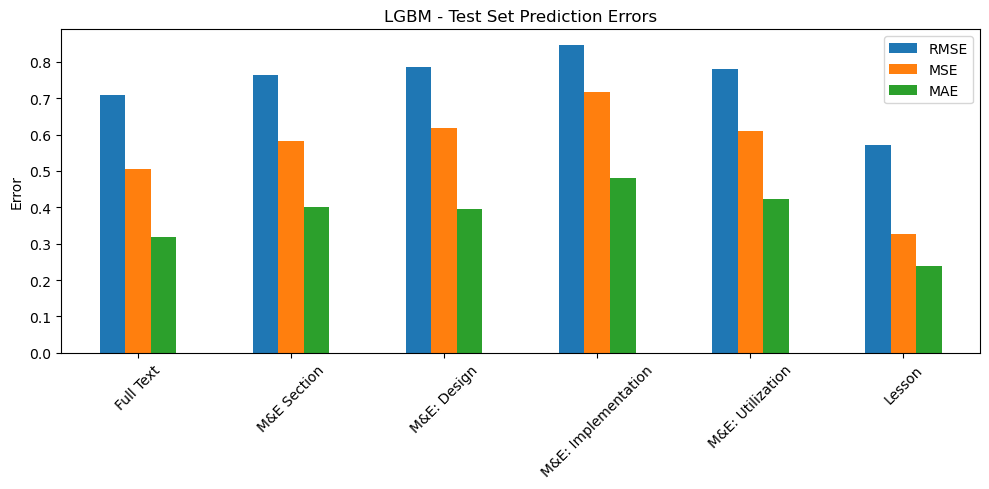

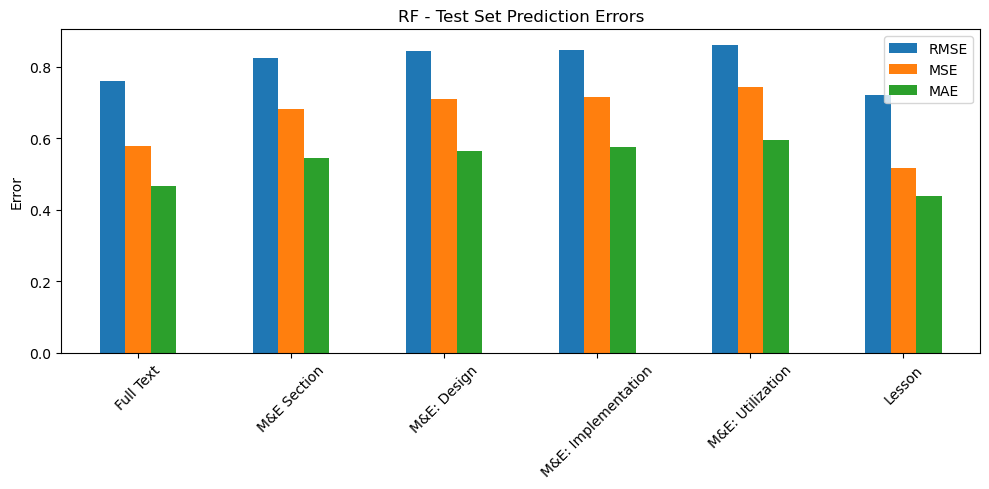

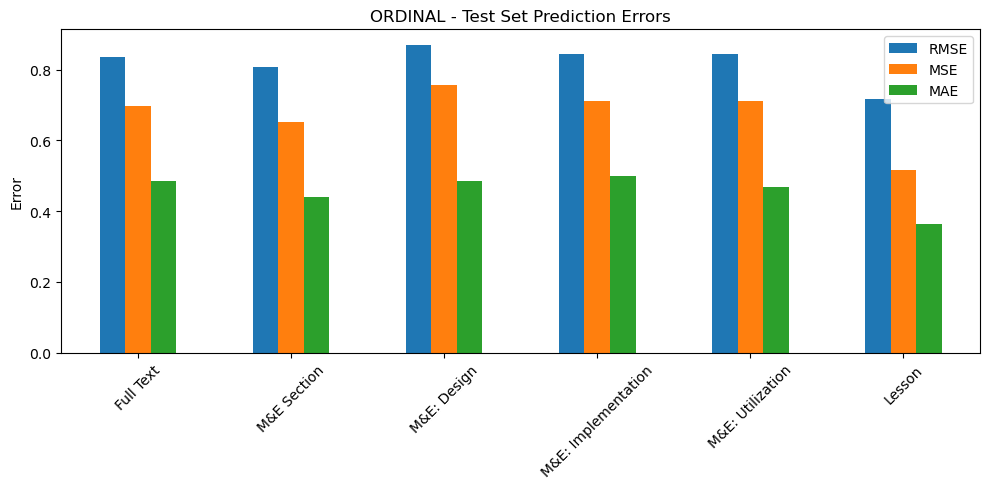

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import os
import pickle
import pandas as pd

metrics_dict = {'lgbm': [], 'rf': [], 'ordinal': []}
labels = ['Full Text', 'M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Lesson']

for model_type in ['lgbm', 'rf', 'ordinal']:
    for var in text_vars:
        filename = os.path.join(dir2, f"model_{model_type}_{var}.pkl")
        with open(filename, 'rb') as f:
            data = pickle.load(f)

        model = data['model']
        vec = data['vectorizer']

        # Reproducir el mismo split que se usó en Optuna
        X_all = vec.transform(df2_cleaned[var])
        y_all = df2_cleaned["outcome_score"].astype(int)
        _, X_test, _, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        metrics_dict[model_type].append({'RMSE': rmse, 'MSE': mse, 'MAE': mae})

# Graficar resultados
for model_type in ['lgbm', 'rf', 'ordinal']:
    df_metric = pd.DataFrame(metrics_dict[model_type], index=labels)
    df_metric = df_metric[['RMSE', 'MSE', 'MAE']]  # Ordenar columnas
    df_metric.plot(kind='bar', figsize=(10, 5), title=f'{model_type.upper()} - Test Set Prediction Errors')
    plt.xticks(rotation=45)
    plt.ylabel("Error")
    plt.tight_layout()
    plt.show()


c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will b

<Figure size 1000x500 with 0 Axes>

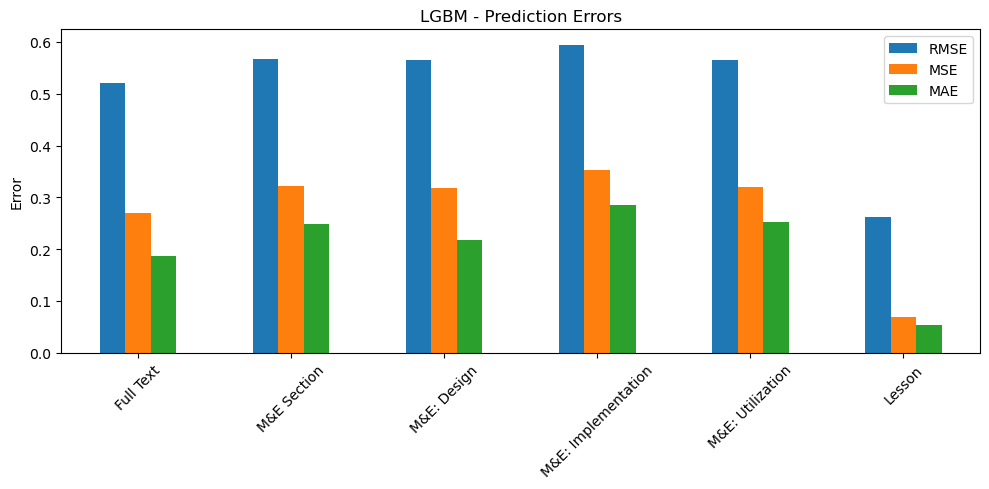

<Figure size 1000x500 with 0 Axes>

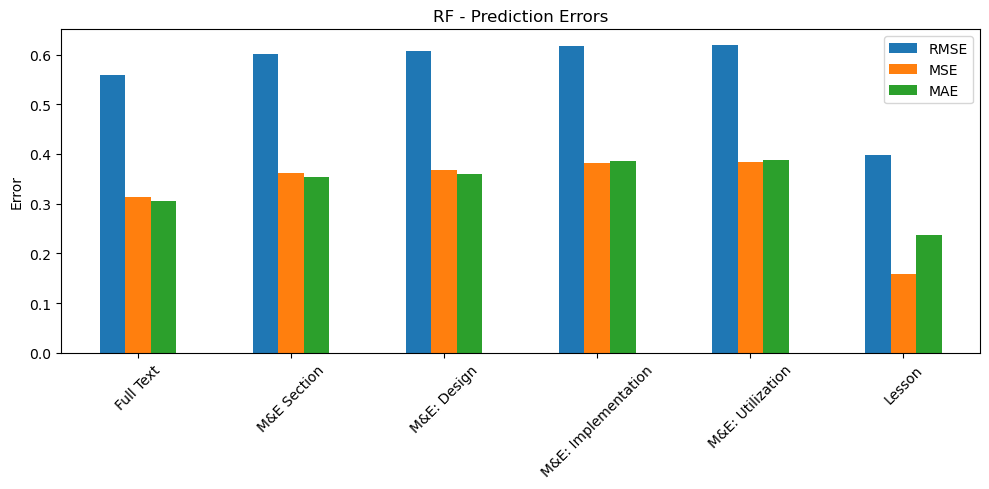

<Figure size 1000x500 with 0 Axes>

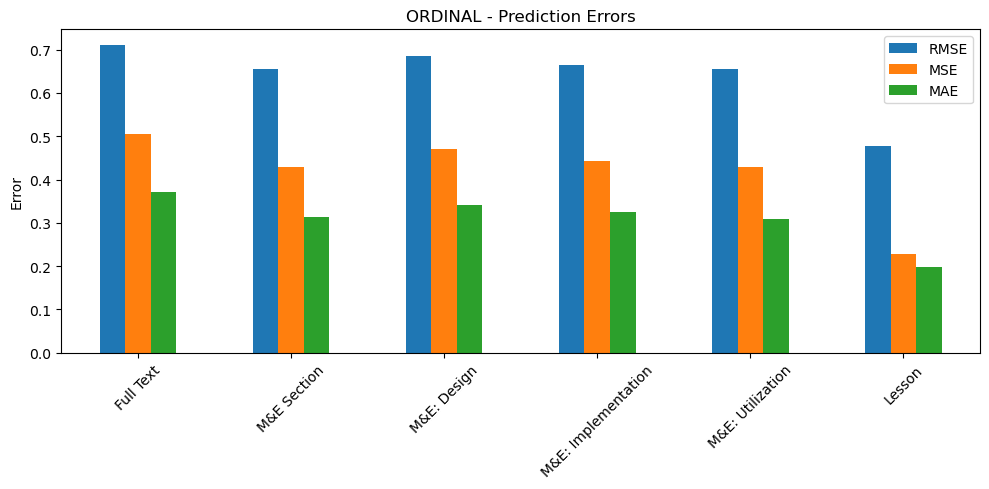

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_dict = {'lgbm': [], 'rf': [], 'ordinal': []}
labels = ['Full Text', 'M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Lesson']

for model_type in ['lgbm', 'rf', 'ordinal']:
    for var in text_vars:
        filename = os.path.join(dir2, f"model_{model_type}_{var}.pkl")
        with open(filename, 'rb') as f:
            data = pickle.load(f)

        model = data['model']
        vec = data['vectorizer']
        X = vec.transform(df2_cleaned[var])
        y = df2_cleaned["outcome_score"].astype(int)
        y_pred = model.predict(X)

        rmse = mean_squared_error(y, y_pred, squared=False)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)

        metrics_dict[model_type].append({'RMSE': rmse, 'MSE': mse, 'MAE': mae})

# Graficar
for model_type in ['lgbm', 'rf', 'ordinal']:
    plt.figure(figsize=(10, 5))
    df_metric = pd.DataFrame(metrics_dict[model_type], index=labels)
    df_metric.plot(kind='bar', figsize=(10,5), title=f'{model_type.upper()} - Prediction Errors')
    plt.xticks(rotation=45)
    plt.ylabel("Error")
    plt.tight_layout()
    plt.show()


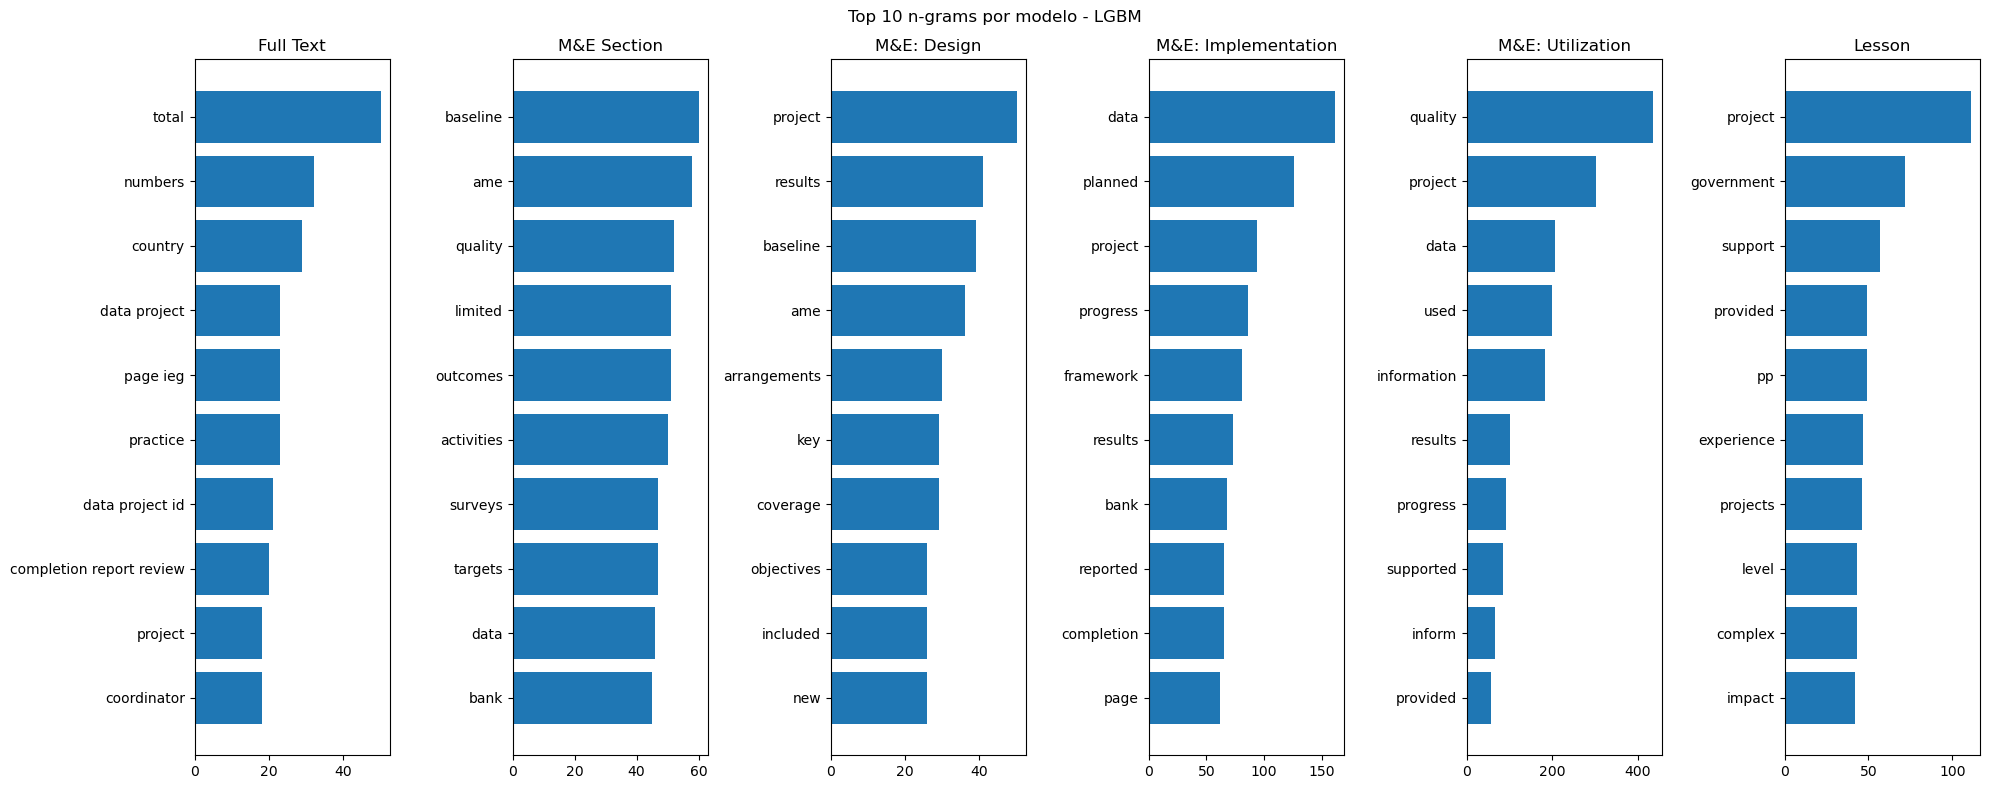

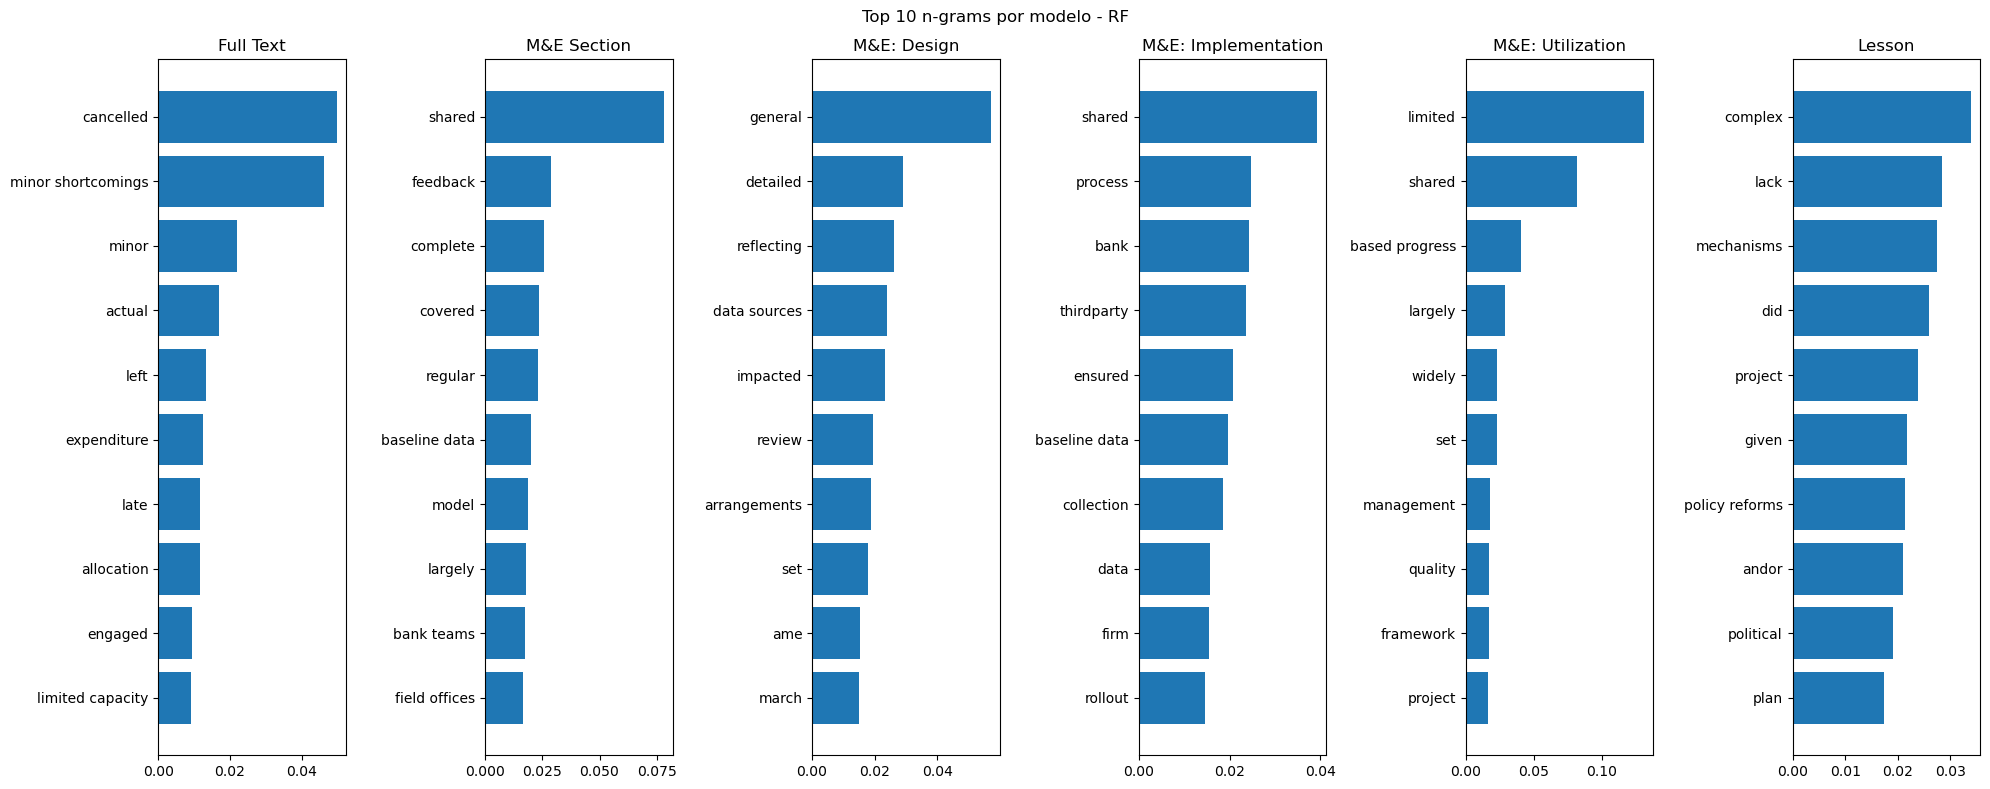

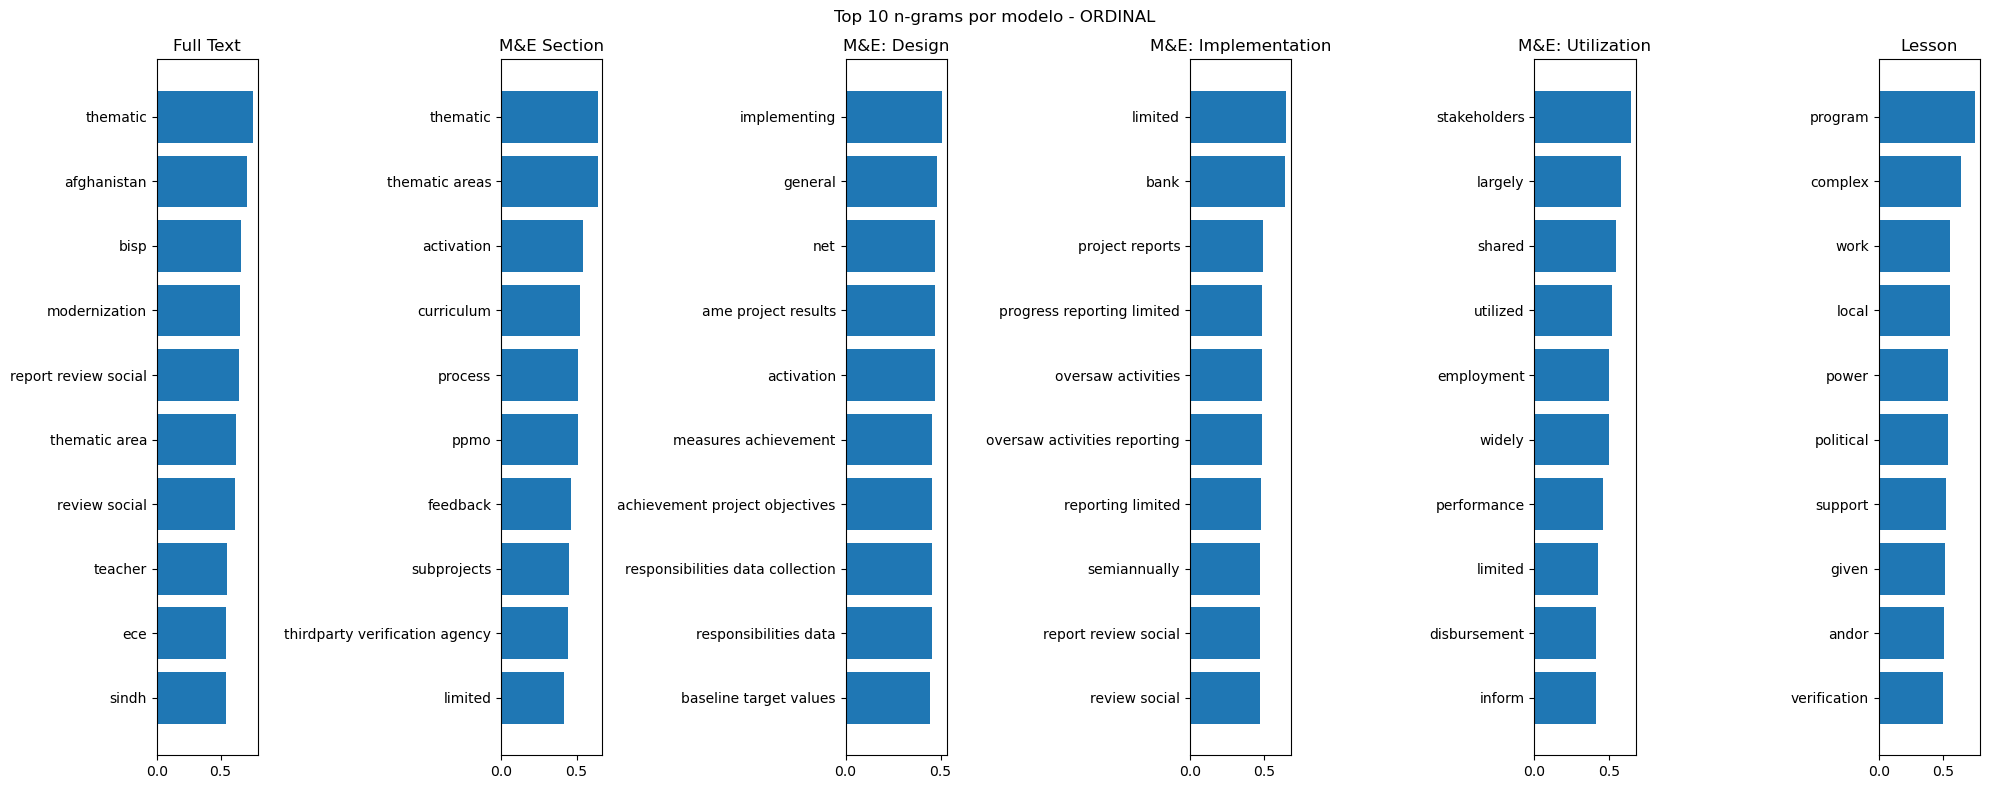

In [46]:
for model_type in ['lgbm', 'rf', 'ordinal']:
    fig, axes = plt.subplots(1, 6, figsize=(20, 8))
    fig.suptitle(f"Top 10 n-grams por modelo - {model_type.upper()}")
    
    for i, var in enumerate(text_vars):
        filename = os.path.join(dir2, f"model_{model_type}_{var}.pkl")
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        model, vec = data['model'], data['vectorizer']
        
        if model_type == 'ordinal':
            importances = np.abs(model.coef_).flatten()
        else:
            importances = model.feature_importances_

        features = np.array(vec.get_feature_names_out())
        idx = np.argsort(importances)[-10:][::-1]
        
        axes[i].barh(features[idx], importances[idx])
        axes[i].set_title(var)
        axes[i].invert_yaxis()

    plt.tight_layout()
    plt.show()
